# Fixed Source Transmutation Problem

Based on 1D model of HYPR system prototype

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Define planar source geometry
xmin = -5
xmax = 5
ymin = -5
ymax = 5
zpos = 0.01

x_dist = openmc.stats.Uniform(xmin,xmax)
y_dist = openmc.stats.Uniform(ymin,ymax)
z_dist = openmc.stats.Discrete([zpos],[1.0])

plan_dist = openmc.stats.CartesianIndependent(x_dist,y_dist,z_dist)
angle_dist = openmc.stats.Monodirectional((0.0,0.0,1.0))

In [3]:
# define settings
settings = openmc.Settings() # create openmc settings object
energy = openmc.stats.Watt() # create energy spectrum of particles
settings.source = openmc.Source(space=plan_dist, energy=energy, angle=angle_dist)
settings.run_mode = 'fixed source'
settings.batches = 100
settings.particles = 20000
settings.generations_per_batch = 1

settings.export_to_xml()

In [4]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238 and Pu238 so depletion works...
target.add_nuclide('Np238',1e-8)
target.add_nuclide('Pu238',1e-8)

target.depletable = True



In [5]:
# create geometry

length = 50. # cm
width = 10.
height = 10.
box = openmc.model.RectangularParallelepiped(-width/2., width/2.,
                                             -height/2., height/2.0,
                                             0., length, boundary_type='vacuum')  

r1 = 35
r2 = 35.23
r3 = 36.23
r4 = 40.23
r5 = 41.23

wwall = openmc.ZPlane(z0 = r1) # wall for water gap between rx and pipe
piwall1 = openmc.ZPlane(z0 = r2) # plane at inner pipe wall
piwall2 = openmc.ZPlane(z0 = r3) 
powall1 = openmc.ZPlane(z0 = r4) 
powall2 = openmc.ZPlane(z0 = r5) 

c1 = openmc.Cell()
c1.region = -box & -wwall
c1.fill = None

c2 = openmc.Cell()
c2.region = -box & +wwall & -piwall1
c2.fill = water

c3 = openmc.Cell()
c3.region = -box & +piwall1 & -piwall2
c3.fill = pipe

c4 = openmc.Cell()
c4.region = -box & +piwall2 & -powall1
c4.fill = target

c5 = openmc.Cell()
c5.region = -box & +powall1 & -powall2
c5.fill = pipe

c6 = openmc.Cell()
c6.region = -box & +powall2
c6.fill = water

root_univ = openmc.Universe()
root_univ.add_cells([c1,c2,c3,c4,c5,c6])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()


target.volume = width*height*(r4 - r3); # compute volume of target material for depletion.

materials = openmc.Materials([water, pipe, target])
materials.export_to_xml()

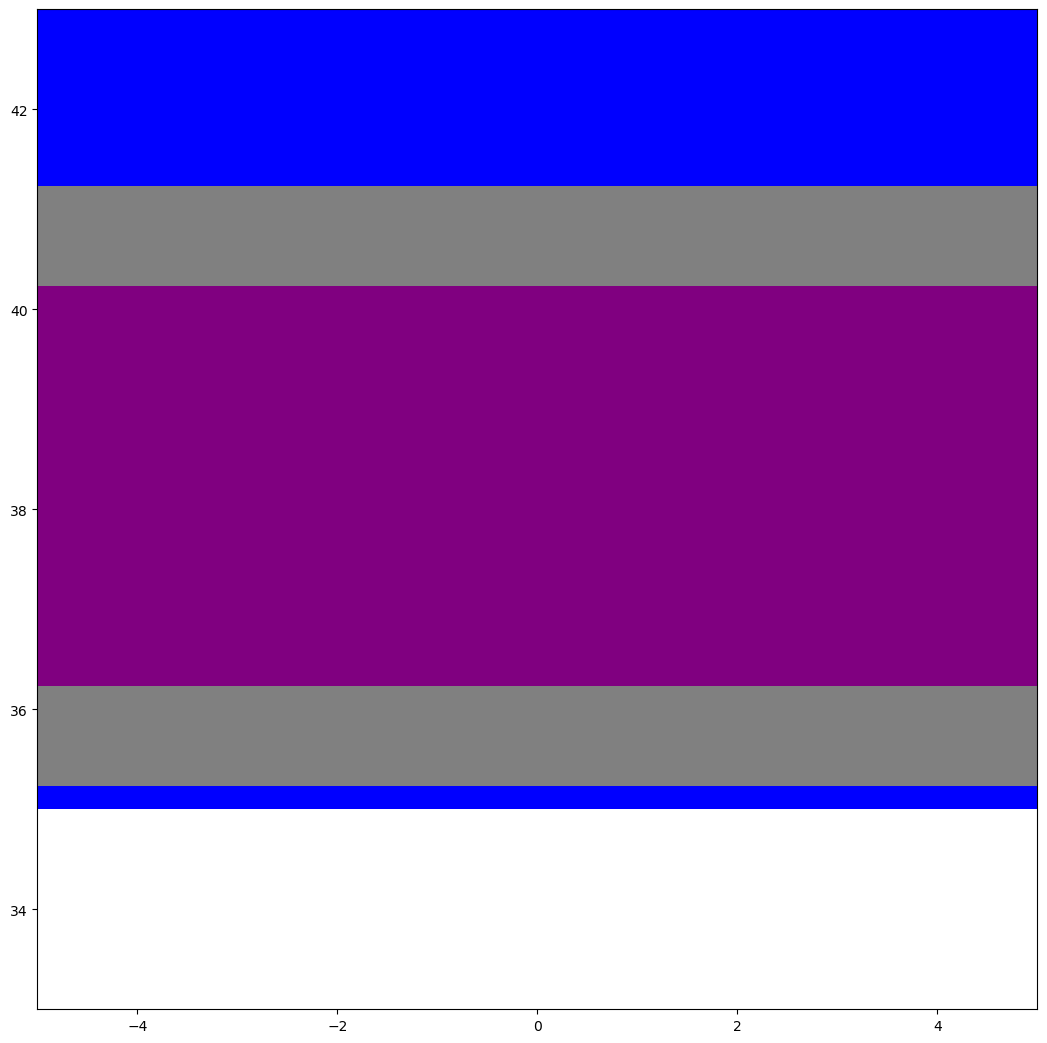

In [6]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,38),width=(width,10),
               pixels=(1000,1000),color_by='material',
               basis='yz',colors=colors)

Add some tallies.

In [7]:
# create tallies

cell_filter = openmc.CellFilter(c4); # measure in the target material cell


# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t]);
#tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t]);
tallies.export_to_xml()

In [ ]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,chain_file="chain_casl_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e14; # n/cm^2-s
source_rate = height*width*avg_flux; # n/s
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5


 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/

 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5


          2500K


 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5
 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5


          1200K
          2500K


 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd147.h5
 Reading Nd148 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT